In [35]:
import matplotlib.pyplot as plt

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [37]:
# Fetch the dataset
newsgroups = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

# Create a DataFrame
df = pd.DataFrame({'text': newsgroups.data, 'target': newsgroups.target})

# Check the first few rows
df.head()

,text,target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


Epoch 1/100, Train Acc: 91.50, Test Acc: 84.22
Epoch 11/100, Train Acc: 99.91, Test Acc: 90.29
Epoch 21/100, Train Acc: 99.73, Test Acc: 88.28
Epoch 31/100, Train Acc: 99.97, Test Acc: 89.95
Epoch 41/100, Train Acc: 99.97, Test Acc: 90.53
Epoch 51/100, Train Acc: 99.98, Test Acc: 90.24
Epoch 61/100, Train Acc: 99.99, Test Acc: 90.16
Epoch 71/100, Train Acc: 99.98, Test Acc: 90.13
Epoch 81/100, Train Acc: 99.98, Test Acc: 90.11
Epoch 91/100, Train Acc: 99.99, Test Acc: 89.42


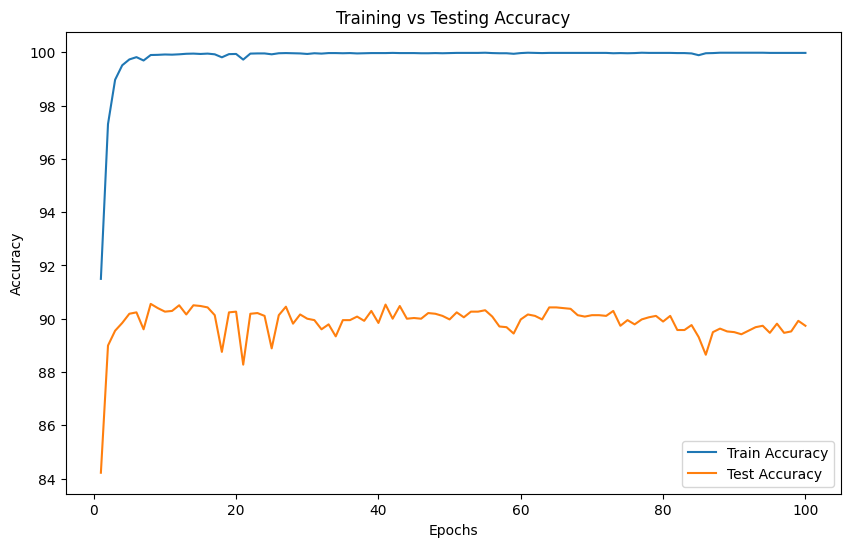

In [38]:
# Text preprocessing and tokenization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(newsgroups.data).toarray()

# Convert labels to tensor and ensure they are long type (class indices)
y = torch.tensor(newsgroups.target).long()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), y_train)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), y_test)

# Increased batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Network model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, num_classes)  # Change output size to number of classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Remove sigmoid activation
        return x

num_classes = len(newsgroups.target_names)  # Number of classes
model = SentimentClassifier(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training and testing loop
epochs = 100
train_accuracy_list = []
test_accuracy_list = []

# Training and testing loop
for epoch in range(epochs):
    # Training
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze().long()
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    # Evaluation on training data
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze().long()
            outputs = model(X_batch)
            predicted = outputs.argmax(dim=1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracy_list.append(train_accuracy)

    # Evaluation on testing data
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze().long()
            outputs = model(X_batch)
            predicted = outputs.argmax(dim=1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    test_accuracy = 100 * correct / total
    test_accuracy_list.append(test_accuracy)

    # Print every 1/10th of epochs
    if epoch % (epochs // 10) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.2f}, Test Acc: {test_accuracy:.2f}')

# Plot training vs testing accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.show()